In [1]:
from model import Network
from data import load_cifar10_dataloaders, WhiteningTransformation
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from criterion import ReconstructImageFromFCLoss
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
# load to model
model_config = './model_config/fc1_cocktail_party_cifar10_instance.json'
checkpoint_path = './checkpoints/122123_fc1_cocktail_party_cifar10_pretraining_wout_bias_without_normalization.pth'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Network(model_config)
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['state_dict'])
model = model.to(device)

# get val loader
batch_size = 4
data_path = './data'
transform = transforms.Compose([
    transforms.ToTensor(),
])

_, val_dataloader = load_cifar10_dataloaders(data_path, batch_size, transform)
selected_val_batch_data, selected_val_batch_label = next(iter(val_dataloader))
selected_val_batch_data = selected_val_batch_data.to(device)
selected_val_batch_label = selected_val_batch_label.to(device)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# receiving gradients
model.zero_grad()
criterion = nn.CrossEntropyLoss()
output = model(selected_val_batch_data.reshape(batch_size, -1))
loss = criterion(output, selected_val_batch_label)
loss.backward()
gradient_of_layers = []
for param in model.parameters():
    gradient_of_layers.append(param.grad.data.clone().to('cpu'))
print([x.size() for x in gradient_of_layers])

[torch.Size([10, 3072])]


In [4]:
whitening_transform = WhiteningTransformation()
whitened_gradient = torch.from_numpy(whitening_transform.transform(gradient_of_layers[0].detach().numpy().T)).to(torch.float32).T
whitened_gradient = whitened_gradient.to(device)

In [5]:
# criterion output testing
unmixing_matrix = torch.rand((selected_val_batch_data.size(0), gradient_of_layers[0].size(0)), requires_grad=True, device=device)
reconstruction_loss = ReconstructImageFromFCLoss(32, 32, 3, 1, 1, 1)
optimizer = torch.optim.Adam([unmixing_matrix])

for iter_idx in range(25000):
    optimizer.zero_grad()
    # out_score, non_gaussianity_score, total_variance_score, mutual_independence_score
    loss, _, _, _ = reconstruction_loss(unmixing_matrix, whitened_gradient)
    loss.backward()
    optimizer.step()
    
    if (iter_idx + 1) % 1000 == 0 or iter_idx == 0:
        print('loss: {}'.format(loss.item()))

loss: 2.330826759338379
loss: 1.0641716718673706
loss: 1.04935622215271
loss: 1.0385596752166748
loss: 1.031636118888855
loss: 1.0267943143844604
loss: 1.0232349634170532
loss: 1.0208137035369873
loss: 1.0184237957000732
loss: 1.0158140659332275
loss: 1.0143098831176758
loss: 1.0126601457595825
loss: 1.012515664100647
loss: 1.0110564231872559
loss: 1.0104564428329468
loss: 1.0102463960647583
loss: 1.009602427482605
loss: 1.0094881057739258
loss: 1.008418083190918
loss: 1.0080739259719849
loss: 1.0077149868011475
loss: 1.0081006288528442
loss: 1.0085757970809937
loss: 1.0065449476242065
loss: 1.0063345432281494
loss: 1.0065584182739258


In [6]:
with torch.no_grad():
    unmixing_matrix = unmixing_matrix.detach().to('cpu')
    whitened_gradient = whitened_gradient.detach().to('cpu')
    estimated_img = unmixing_matrix @ whitened_gradient

In [7]:
estimated_img

tensor([[-0.0037, -0.0070, -0.0062,  ...,  0.0014,  0.0028,  0.0023],
        [-0.0010, -0.0010, -0.0018,  ..., -0.0015, -0.0015, -0.0011],
        [ 0.0016,  0.0009,  0.0008,  ...,  0.0034,  0.0039,  0.0033],
        [-0.0016, -0.0021, -0.0018,  ...,  0.0036,  0.0034,  0.0032]])

## Estimated images

In [8]:
import matplotlib.colors as colors

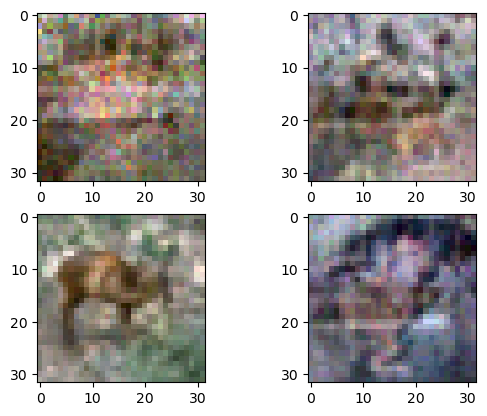

In [15]:
with torch.no_grad():
    unmixing_matrix = unmixing_matrix.detach().to('cpu')
    whitened_gradient = whitened_gradient.detach().to('cpu')
    estimated_img = unmixing_matrix @ whitened_gradient
    
    fig, axes = plt.subplots(2, 2)
    
    for estimate, ax in zip(estimated_img, axes.flatten()):
        # img = [colors.Normalize()(np.asarray(dimension)) for dimension in estimate.reshape(3, 32, 32)]
        img = colors.Normalize()(np.asarray(-estimate)).reshape(3, 32, 32).transpose(1, 2, 0)
        # img = np.stack(img, axis=-1)
        # print(img.shape)
        ax.imshow(img)
    plt.show()

## Original images

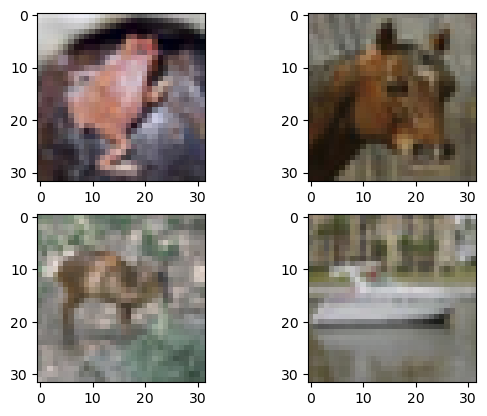

In [10]:
with torch.no_grad():
    fig, axes = plt.subplots(2, 2)
    
    for estimate, ax in zip(selected_val_batch_data, axes.flatten()):
        img = transforms.ToPILImage()(torch.clamp(estimate.reshape(3, 32, 32), min=-1, max=1))
        img = np.asarray(img)
        ax.imshow(img)
    plt.show()